In [10]:
!pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 615.0 kB/s eta 0:00:00a 0:00:01


In [11]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import folium
import geopandas as gpd
from shapely.geometry import Point

In [2]:
conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [3]:
query = """select * from mat_orders"""

df = pd.read_sql(query, con=conn_string)

In [4]:
cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    AND created_at < '2023-07-01'
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

# Geographic Spread

In [5]:
lonlat_query = """select partner_name || ' - ' || space_name as space_name
    , coalesce(mat_orders.city, locations.city) as city
    , coalesce(mat_orders.country, locations.country) as country
    , coalesce(mat_orders.state, locations.state) as state
    , longitude
    , latitude
    , count(order_id)
from mat_orders
left join locations
    on mat_orders.location_id = locations.id
where 1=1
and source in ('WL', 'FM')
AND status ='paid'
AND mat_orders.created_at < '2023-07-01'
 AND email NOT IN (
      SELECT
        email
      FROM
        mat_orders
      WHERE
        1 = 1
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%'
          OR email ILIKE '%%test%%'
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    )
group by 1,2,3,4,5,6;

"""

locations_ = pd.read_sql(lonlat_query, con=conn_string)

In [7]:
import geopandas as gpd

locations_ = locations_.dropna(thresh=5).copy()
gdf_ = gpd.GeoDataFrame(locations_, geometry=gpd.points_from_xy(locations_['longitude'], locations_['latitude']))

In [16]:
import folium

def create_maps(gdf, is_global=True):
    
    def map_creator(temp_df, city):    
        # Add points to the map
        for idx, row in temp.iterrows():
            popup_text = str(row['count'])

            folium.CircleMarker(location=(row['latitude'], row['longitude']),
                                radius=row['count']/10, # change this value to adjust the size of the circle markers
                                color="blue", 
                                popup=folium.Popup(popup_text), 
                                fill=True).add_to(m)

            m.save(f"{city.title()}.html")
        
    if is_global:
        temp = gdf[['latitude', 'longitude', 'city','count']].copy()
        temp = temp.groupby(['latitude','longitude'], as_index=False).sum(numeric_only=True).copy()
        m = folium.Map(location=[30.261042, -73.993123], zoom_start=5)
        map_creator(temp, "Global")
    else:
        for city in gdf['city'].unique():
            temp = gdf[gdf['city']==city][['latitude', 'longitude', 'city','count']].copy()
            temp = temp.groupby(['latitude','longitude'], as_index=False).sum(numeric_only=True).copy()
            m = folium.Map(location=[temp['latitude'].mean(numeric_only=True), temp['longitude'].mean(numeric_only=True)], zoom_start=13)

            map_creator(temp, city)

In [17]:
create_maps(gdf_)
create_maps(gdf_, False)

<Axes: title={'center': 'Mean final price per operator distribution'}>

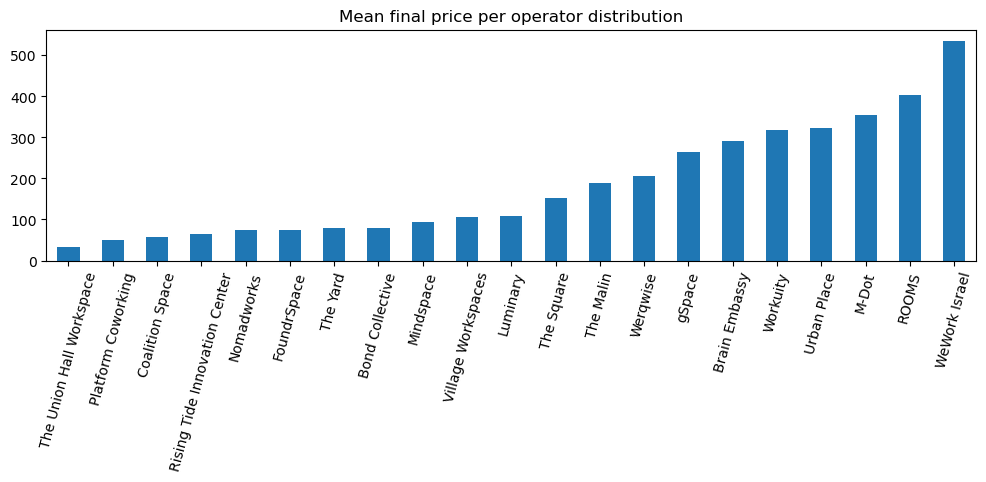

In [15]:
filtered_df.groupby('operator_name').mean(numeric_only=True)['final_price'].sort_values().plot(kind="bar", xlabel="", 
                                                                              rot=75,
                                                                              figsize=(12,3),
                                                                              title="Mean final price per operator distribution")

In [19]:
filtered_df.groupby('operator_name').sum(numeric_only=True)['final_price'].sort_values()

operator_name
The Union Hall Workspace             395.00
Coalition Space                      455.00
The Square                           760.00
Platform Coworking                   815.00
Workuity                             950.00
Rising Tide Innovation Center       1847.50
gSpace                              1850.00
Village Workspaces                  7271.60
FoundrSpace                        10972.50
Bond Collective                    30043.75
M-Dot                              35695.53
Nomadworks                         69556.50
Luminary                           84839.75
ROOMS                             105019.20
Werqwise                          115175.50
Brain Embassy                     176435.66
Urban Place                       201909.38
The Malin                         256210.25
The Yard                          269103.00
Mindspace                         862619.47
WeWork Israel                    2279715.41
Name: final_price, dtype: float64

In [20]:
# Extracting just the date from created_at as date
filtered_df['date'] = filtered_df['created_at'].dt.date

filtered_df['date'].count()

22696

In [21]:
filtered_df['date'].describe()

count          22696
unique           821
top       2023-06-21
freq             100
Name: date, dtype: object

In [22]:
# Number of unique operators
filtered_df['operator_id'].nunique()

21

In [23]:
fdf = filtered_df

# Features for Success

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Convert 'date' to a time stamp
fdf['date'] = pd.to_datetime(fdf['date'])
monetary_for_preperation = fdf.groupby(['operator_id', 'customer_email','date'], as_index=False)['final_price'].sum()
interim_fdf = fdf.sort_values(['operator_id', 'customer_email','created_at']).drop_duplicates(['operator_id', 'customer_email','date'])
interim_fdf = interim_fdf.drop('final_price', axis=1)

In [26]:
fdf = interim_fdf.merge(monetary_for_preperation).copy()

In [27]:
country_totals = pd.DataFrame(fdf.groupby('country', as_index = False)['final_price_usd'].sum(numeric_only=True))

In [28]:
country_totals = country_totals.sort_values(by='final_price_usd', ascending=False).reset_index(drop=True)

In [29]:
country_totals


,country,final_price_usd
0,US,868369.54
1,IL,741107.85
2,DE,340928.25
3,GB,125481.03
4,NL,63256.89
5,PL,36958.07
6,RO,24499.01


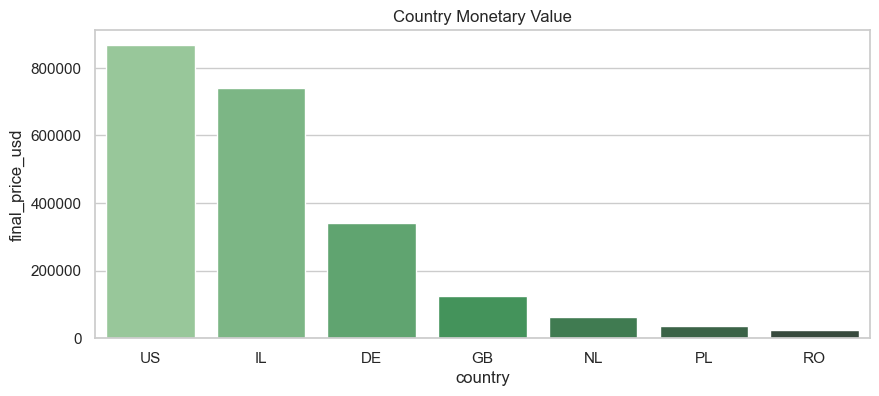

In [31]:
plt.figure(figsize=(10,4))

sns.set(style='whitegrid', color_codes=True)

pal = sns.color_palette('Greens_d', len(country_totals))

# Swap x and y for vertical bars
sns.barplot(x=country_totals['country'], y=country_totals['final_price_usd'], palette=pal)

plt.title('Country Monetary Value')
plt.xticks()
plt.show()

In [32]:
country_operator = pd.DataFrame(fdf.groupby('country', as_index = False)['operator_name'].nunique()).sort_values(by='operator_name', ascending=False).reset_index(drop=True)

                                                                                                               

In [33]:
country_operator

,country,operator_name
0,US,16
1,IL,6
2,PL,2
3,DE,1
4,GB,1
5,NL,1
6,RO,1


Text(0.5, 1.0, 'Operators in each Country')

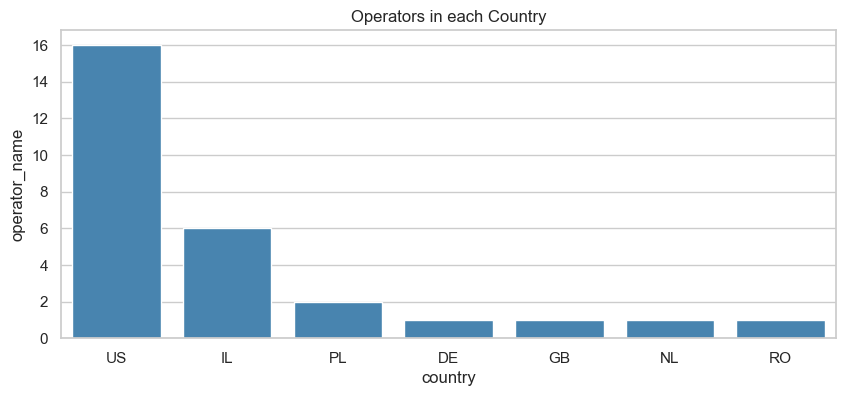

In [35]:
plt.figure(figsize = (10, 4))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Blues_d", 1)

sns.barplot(x=country_operator['country'], y=country_operator['operator_name'], palette=pal)

plt.title('Operators in each Country')

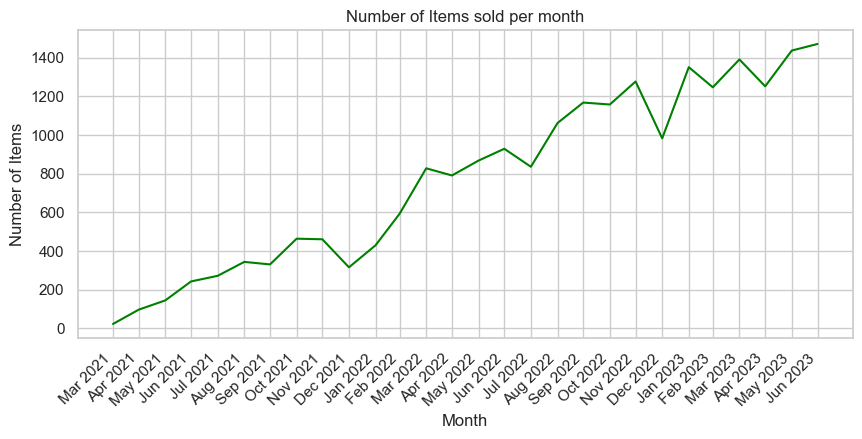

In [36]:
df_group = pd.DataFrame(fdf.resample('M', on='date')['order_id'].count())
df_group.columns = ['Number_of_items_sold']
    
plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group.index, y=df_group['Number_of_items_sold'], color = 'Green')

# Set the chart title and axis labels
plt.title('Number of Items sold per month')
plt.xlabel('Month')
plt.ylabel('Number of Items')

plt.xticks(df_group.index, df_group.index.strftime('%b %Y'), rotation=45, ha='right')
plt.show()

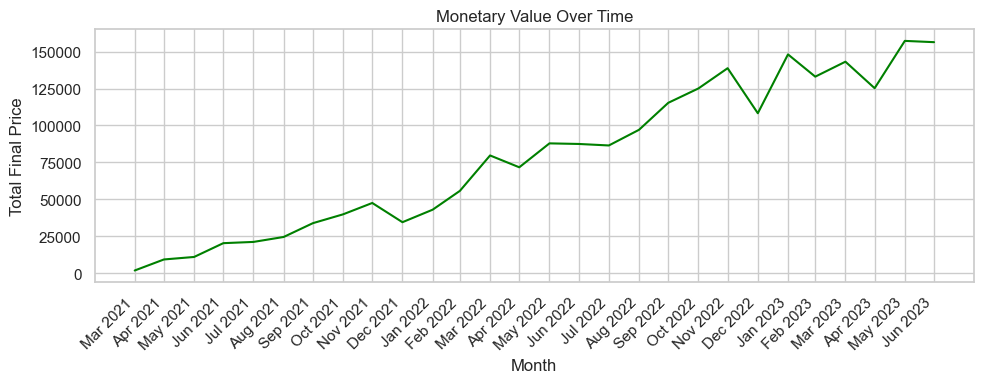

In [70]:
# Resample by month and sum the final_price
df_group = fdf.resample('M', on='date')['final_price_usd'].sum()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Total_final_price'], color = 'Green')

# Set the chart title and axis labels
plt.title('Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

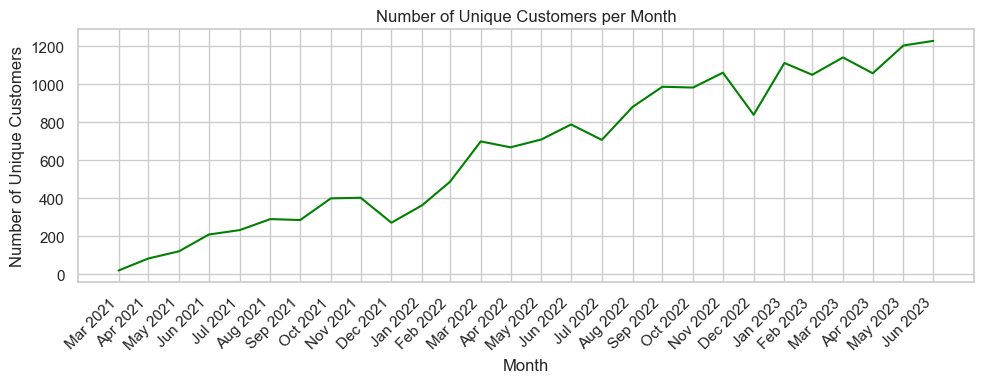

In [71]:
# Resample by month and count the unique emails
df_group = fdf.resample('M', on='date').customer_email.nunique()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Number_of_unique_customers']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Number_of_unique_customers'], color = 'Green')

# Set the chart title and axis labels
plt.title('Number of Unique Customers per Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Customers')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# RFM Function

In [82]:
fdf['operator_key'] = fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']
fdf['operator_full_name'] = fdf['operator_name']+"-"+fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']

pivot_table = fdf.groupby(['operator_name', 'operator_key']).size().unstack(fill_value=0)

# pivot_table.astype(bool).sum(axis=1).sort_values(ascending=False)

In [83]:
def create_extended_rfm_by(fdf_, key="operator_name"):

    # this is a bogus filter - you can change that however you like
    fdf_filtered = fdf_[fdf_['date'] < pd.to_datetime('2023-07-01')].copy()
    
    #recency and lifetime
    df_recency = fdf_filtered.groupby(key)['date'].agg(["max", "min"]).reset_index()
    df_recency.columns = ['operator', 'last_order', "first_order"]
    
    df_recency['recency'] = (pd.Timestamp.now().normalize() - df_recency['last_order']).dt.days
    df_recency['lifetime'] = (df_recency['last_order'] - df_recency['first_order']).dt.days+1
    
    #monetary and frequency 
    df_monetary_freq = fdf_filtered.groupby(key)['final_price_usd'].agg(['count', sum]).copy().reset_index()
    df_monetary_freq.columns = ['operator', 'frequency', "monetary"]

    
    # Count number of orders for each customer and partner
    df_orders = fdf_filtered.groupby([key, 'customer_email']).size().reset_index(name='orders')
    # Calculate whether the customer has returned (1 if 'orders' > 1, 0 otherwise)
    df_orders['returned'] = (df_orders['orders'] > 1).astype(int)

    # Now group by partner_name and calculate total customers and returning customers
    df_final = df_orders.groupby(key).agg(total_customers=('customer_email', 'count'), returning_customers=('returned', 'sum')).reset_index()
    df_final['return_rate'] = df_final['returning_customers'] / df_final['total_customers']
    #df_final = df_final.drop(['returning_customers', 'total_customers'], axis=1).copy()
    df_final.columns = ['operator', "total_customers", "returning_customers", "return_rate"]
    
    df = df_recency.merge(df_monetary_freq).merge(df_final).copy()
    df = df.drop(['last_order','first_order','returning_customers'], axis=1)
    df['intensity'] = df['frequency']/df['lifetime']
    return df

In [84]:
rfm_by_operator_name = create_extended_rfm_by(fdf)
rfm_by_full_name = create_extended_rfm_by(fdf, key="operator_full_name")

In [85]:
rfm_by_full_name

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
0,Bond Collective-US-CA-Los Angeles,26,85,21,1362.50,20,0.050000,0.247059
1,Bond Collective-US-DC-Washington,97,9,5,125.00,3,0.666667,0.555556
2,Bond Collective-US-IL-Chicago,23,91,46,5650.00,43,0.069767,0.505495
3,Bond Collective-US-NY-Brooklyn,23,89,173,9650.00,136,0.198529,1.943820
4,Bond Collective-US-NY-New York,24,80,59,4143.75,49,0.142857,0.737500
...,...,...,...,...,...,...,...,...
57,Werqwise-US-CA-San Francisco,25,595,340,62219.75,267,0.168539,0.571429
58,Werqwise-US-CA-San Mateo,23,541,185,36028.50,150,0.133333,0.341959
59,Workuity-US-AZ-Chandler,26,2,3,950.00,2,0.500000,1.500000
60,gSpace-US-CT-Fairfield,54,43,3,750.00,2,0.500000,0.069767


In [89]:
fdf['operator_key'] = fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']
fdf['operator_full_name'] = fdf['operator_name']+"-"+fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']

pivot_table = fdf.groupby(['operator_name', 'operator_key']).size().unstack(fill_value=0)

# pivot_table.astype(bool).sum(axis=1).sort_values(ascending=False)

In [104]:
def promotion_analysis(fdf_, key='operator_name'):
    
    # Filter by date
    fdf_filter = fdf_[(fdf_['date'] < pd.to_datetime('2023-07-01')) & (fdf['date'] >= pd.to_datetime('2023-01-01'))]
    
    # Filter out null values for promotion_code
    fdf_filter = fdf_filter[fdf_filter['promotion_code'].notnull()]
    
    # Group by 'key' (default is 'operator_name') and 'promotion_code', then count the occurrences
    result = fdf_filter.groupby([key, 'promotion_code']).size().reset_index(name='count')
    result.columns = ('operator', 'promotion code', 'count')

    return result

result_df_by_operator_name = promotion_analysis(fdf)
result_df_by_full_name = promotion_analysis(fdf, key="operator_full_name")


indices_to_drop = result_df_by_full_name[result_df_by_full_name['promotion code'] == ''].index
result_df_by_full_name.drop(indices_to_drop, inplace=True)


result_df_by_full_name = result_df_by_full_name.sort_values(by='count', ascending=False)

result_df_by_full_name

,operator,promotion code,count
16,Luminary-US-NY-New York,LUMMEMBER,187
165,WeWork Israel-IL-Tel Aviv,AZRIELI50,105
171,WeWork Israel-IL-Tel Aviv,SHAULHAMELECH50,35
175,WeWork Israel-IL-Tel Aviv,WEWORK25,29
24,Mindspace-DE-Berlin,PRIDE2023,22
...,...,...,...
129,WeWork Israel-IL-Haifa,WWWOFU25,1
128,WeWork Israel-IL-Haifa,WWMAJC15,1
127,WeWork Israel-IL-Haifa,WWLULA25,1
126,WeWork Israel-IL-Haifa,WWDESK20,1


In [116]:
def promotion_analysis(fdf_, key='operator_name'):
    
     # Identify promotion codes used before January 01, 2023
    excluded_promo_codes = fdf_[fdf_['date'] < pd.to_datetime('2023-01-01')]['promotion_code'].unique()
    
    # Filter by date
    fdf_filter = fdf_[(fdf_['date'] < pd.to_datetime('2023-07-01')) & (fdf['date'] >= pd.to_datetime('2023-01-01'))]
    
    # Filter out null values for promotion_code
    fdf_filter = fdf_filter[fdf_filter['promotion_code'].notnull()]
    
    # Exclude the promotion codes that were used before January 01, 2023
    fdf_filter = fdf_filter[~fdf_filter['promotion_code'].isin(excluded_promo_codes)]
    
    # Group by 'key' (default is 'operator_name') and 'promotion_code', then count the occurrences
    result = fdf_filter.groupby([key, 'promotion_code']).size().reset_index(name='count')
    result.columns = ('operator', 'promotion code', 'count')

    return result

result_df_by_operator_name = promotion_analysis(fdf)
result_df_by_full_name = promotion_analysis(fdf, key="operator_full_name")


indices_to_drop = result_df_by_full_name[result_df_by_full_name['promotion code'] == ''].index
result_df_by_full_name.drop(indices_to_drop, inplace=True)


result_df_by_full_name = result_df_by_full_name.sort_values(by='count', ascending=False)

result_df_by_full_name

,operator,promotion code,count
71,WeWork Israel-IL-Tel Aviv,AZRIELI50,105
77,WeWork Israel-IL-Tel Aviv,SHAULHAMELECH50,35
81,WeWork Israel-IL-Tel Aviv,WEWORK25,29
3,Mindspace-DE-Berlin,PRIDE2023,22
75,WeWork Israel-IL-Tel Aviv,NETA,15
...,...,...,...
47,WeWork Israel-IL-Herzliya,WWKZBL15,1
46,WeWork Israel-IL-Herzliya,WWKYVN20,1
45,WeWork Israel-IL-Herzliya,WWJH1Z10,1
44,WeWork Israel-IL-Herzliya,WWCMA315,1


In [132]:
result_df_by_full_name.head(10)

,operator,promotion code,count
71,WeWork Israel-IL-Tel Aviv,AZRIELI50,105
77,WeWork Israel-IL-Tel Aviv,SHAULHAMELECH50,35
81,WeWork Israel-IL-Tel Aviv,WEWORK25,29
3,Mindspace-DE-Berlin,PRIDE2023,22
75,WeWork Israel-IL-Tel Aviv,NETA,15
10,Mindspace-DE-Munich,PRIDE2023,13
21,ROOMS-IL-Petah Tikva,ROOMS50,11
82,WeWork Israel-IL-Tel Aviv,WEWORK50,9
72,WeWork Israel-IL-Tel Aviv,AZRIELITOWN20,9
25,ROOMS-IL-Tel Aviv,ROOMS50,9


In [123]:
result_df_by_full_name_2 = result_df_by_full_name[result_df_by_full_name['count']>2]

result_df_by_full_name_2.head()

,operator,promotion code,count
71,WeWork Israel-IL-Tel Aviv,AZRIELI50,105
77,WeWork Israel-IL-Tel Aviv,SHAULHAMELECH50,35
81,WeWork Israel-IL-Tel Aviv,WEWORK25,29
3,Mindspace-DE-Berlin,PRIDE2023,22
75,WeWork Israel-IL-Tel Aviv,NETA,15


In [125]:
# Filter the data for the desired promotion code
promo_azrieli = fdf[fdf['promotion_code'] == "AZRIELI50"]

# Group by 'operator_name' and 'date' and then count the occurrences (or another aggregation you prefer)
promo_azrieli_date = promo_azrieli.groupby(['operator_name', 'date']).size().reset_index(name='count')

# Sort by date for better visibility
promo_azrieli_date = promo_azrieli_date.sort_values(by=['date'])

promo_azrieli_date


,operator_name,date,count
0,WeWork Israel,2023-01-02,5
1,WeWork Israel,2023-01-03,2
2,WeWork Israel,2023-01-05,5
3,WeWork Israel,2023-01-08,3
4,WeWork Israel,2023-01-09,4
5,WeWork Israel,2023-01-10,1
6,WeWork Israel,2023-01-11,2
7,WeWork Israel,2023-01-12,2
8,WeWork Israel,2023-01-15,3
9,WeWork Israel,2023-01-16,2


In [114]:
fdf_promo_date = fdf.groupby('promotion_code')['date'].apply(list).reset_index()


fdf_promo_date

,promotion_code,date
0,,"[2023-06-26 00:00:00, 2023-06-27 00:00:00, 202..."
1,25wework,"[2022-12-26 00:00:00, 2022-12-28 00:00:00]"
2,ANDREA15,"[2023-01-20 00:00:00, 2023-01-21 00:00:00]"
3,AZRIELI25,[2023-03-27 00:00:00]
4,AZRIELI50,"[2023-02-02 00:00:00, 2023-03-12 00:00:00, 202..."
...,...,...
205,pride2023,"[2023-06-19 00:00:00, 2023-06-12 00:00:00, 202..."
206,rooms50,"[2023-06-21 00:00:00, 2023-06-07 00:00:00]"
207,werq2,[2023-06-22 00:00:00]
208,wework25,[2023-06-25 00:00:00]


In [128]:
# Pivot the data
pivot_df_code = result_df_by_full_name.pivot(index='operator', columns='promotion code', values='count').fillna(0)

pivot_df_code

promotion code,ANDREA15,AZRIELI25,AZRIELI50,AZRIELITOWN20,BUYWITH15,COFFEEATMINDSPACE,DANNY15,DAYPASS10,IRONALGO,LIRONMOR,...,WWXXEC15,WWZK5Q10,Wework25,founders25,gspace-4day,gspace350,pride2023,rooms50,werq2,wework25
operator,,,,,,,,,,,,,,,,,,,,,
Bond Collective-US-NY-New York,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Luminary-US-NY-New York,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mindspace-DE-Berlin,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
Mindspace-DE-Frankfurt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mindspace-DE-Hamburg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mindspace-DE-Munich,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mindspace-GB-London,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Mindspace-NL-Amsterdam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mindspace-PL-Warsaw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


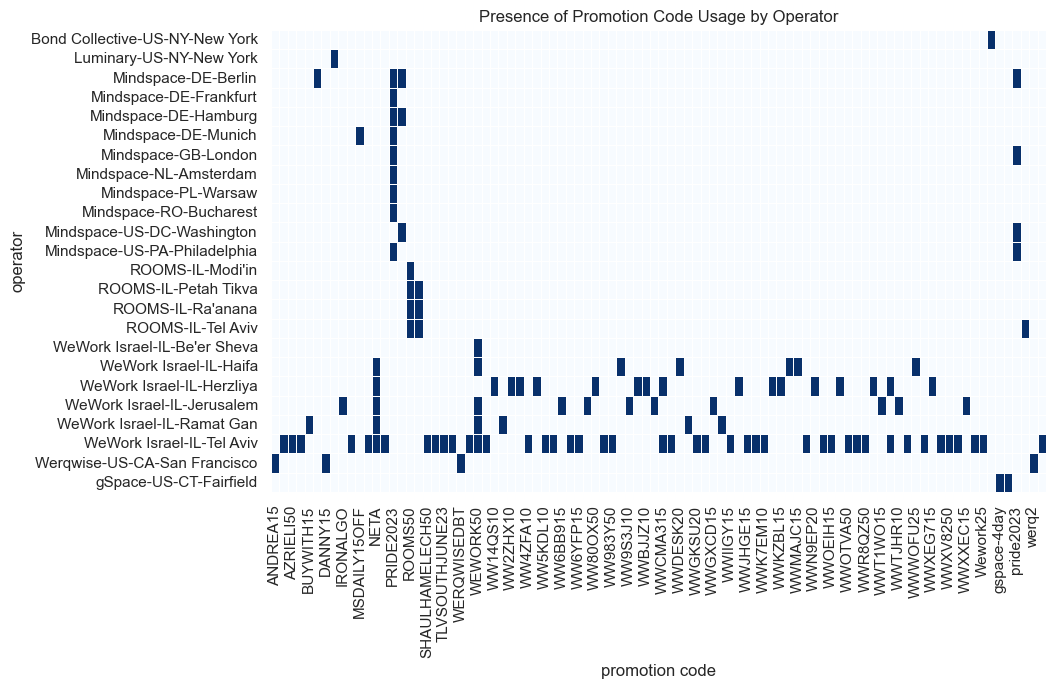

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the data
pivot_df = result_df_by_full_name.pivot(index='operator', columns='promotion code', values='count').fillna(0)

# Convert counts to boolean
binary_df = (pivot_df > 0).astype(int)

# Plot the heatmap
plt.figure(figsize=(10, 6))  # Adjust the size if needed
sns.heatmap(binary_df, cmap="Blues", cbar=False, linewidths=.5)
plt.title("Presence of Promotion Code Usage by Operator")
plt.show()


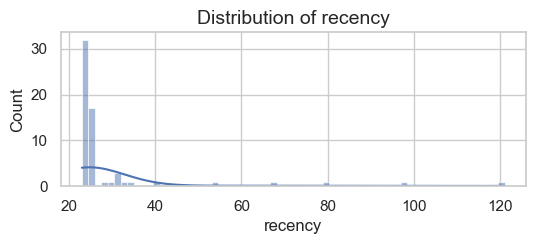

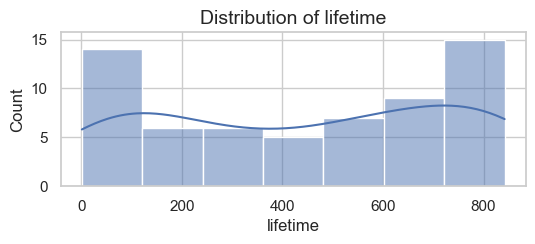

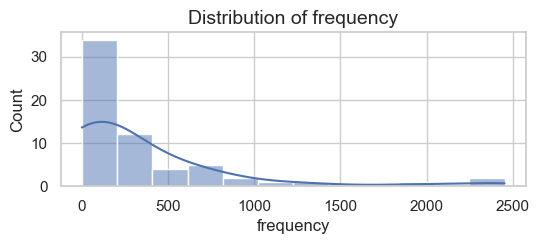

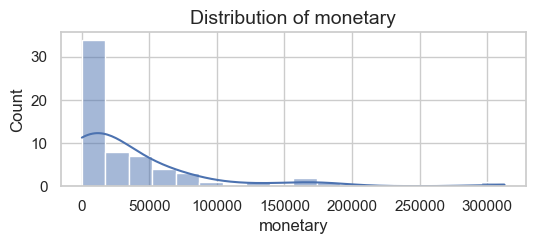

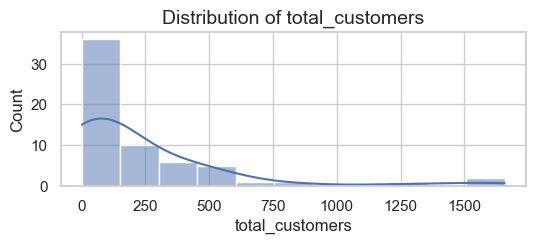

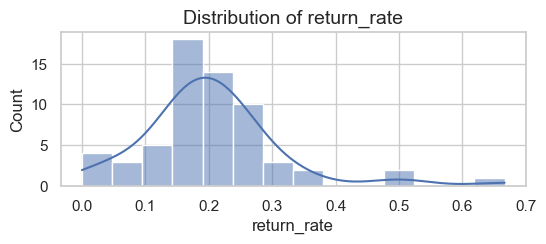

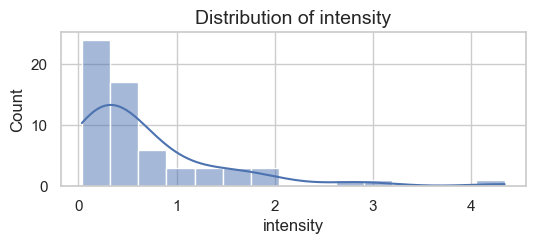

In [46]:
# Create separate plots for each numeric column
for col in rfm_by_full_name.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 2))
    sns.histplot(data=rfm_by_full_name, x=col, kde=True)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.show()

In [47]:
rfm_by_full_name.sort_values('return_rate', ascending=False)

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
1,Bond Collective-US-DC-Washington,97,9,5,125.00,3,0.666667,0.555556
60,gSpace-US-CT-Fairfield,54,43,3,750.00,2,0.500000,0.069767
59,Workuity-US-AZ-Chandler,26,2,3,950.00,2,0.500000,1.500000
24,Mindspace-IL-Yakum,24,586,80,10959.77,33,0.363636,0.136519
18,Mindspace-GB-London,23,820,1157,125481.03,531,0.333333,1.410976
...,...,...,...,...,...,...,...,...
0,Bond Collective-US-CA-Los Angeles,26,85,21,1362.50,20,0.050000,0.247059
5,Bond Collective-US-PA-Philadelphia,23,80,23,1900.00,22,0.045455,0.287500
35,ROOMS-IL-Modi'in,26,300,27,2434.82,26,0.038462,0.090000
20,Mindspace-IL-Kiryat Ono,26,21,5,402.39,5,0.000000,0.238095


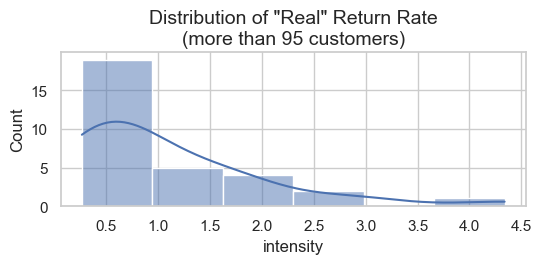

In [48]:
more_than_median =rfm_by_full_name[rfm_by_full_name['total_customers']>rfm_by_full_name['total_customers'].median()].copy()
plt.figure(figsize=(6, 2))
sns.histplot(data=more_than_median, x=col, kde=True)
plt.title(f'Distribution of "Real" Return Rate\n(more than 95 customers)', fontsize=14)
plt.show()

# Segmentation

In [50]:
rfm_by_full_name.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,62.000000,62.000000,62.000000,62.00000,62.000000,62.000000,62.000000
mean,29.983871,446.338710,350.548387,35493.55871,234.564516,0.204469,0.700075
std,17.701988,297.078669,524.059616,55098.78111,344.225032,0.111132,0.797688
min,23.000000,1.000000,1.000000,125.00000,1.000000,0.000000,0.036232
25%,23.000000,140.250000,34.500000,3759.32250,25.250000,0.154600,0.237086
50%,24.000000,488.500000,142.000000,11180.08000,94.500000,0.198697,0.381385
75%,26.000000,706.250000,453.750000,39026.84750,327.750000,0.249282,0.843671
max,121.000000,842.000000,2452.000000,312877.81000,1658.000000,0.666667,4.339552


In [51]:

number_of_days_for_recency = 45
new_operators_days_thresh = 90

In [59]:
recency_75 = rfm_by_full_name[rfm_by_full_name['recency']>26].sort_values(by='recency', ascending=False)

In [60]:
recency_75.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,52.153846,269.461538,47.307692,4843.402308,37.076923,0.211892,0.264640
std,30.234765,276.256407,55.784383,5327.429184,48.487905,0.179267,0.274119
min,28.000000,1.000000,1.000000,125.000000,1.000000,0.000000,0.036232
25%,31.000000,88.000000,5.000000,750.000000,4.000000,0.120000,0.068182
50%,34.000000,147.000000,28.000000,1637.500000,25.000000,0.166667,0.190476
75%,67.000000,368.000000,69.000000,8923.260000,55.000000,0.200000,0.375486
max,121.000000,804.000000,193.000000,17270.000000,176.000000,0.666667,1.000000


In [61]:
recency_75

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
50,Village Workspaces-US-CA-Los Angeles,121,173,67,6947.60,54,0.166667,0.387283
1,Bond Collective-US-DC-Washington,97,9,5,125.00,3,0.666667,0.555556
9,Coalition Space-US-NY-New York,80,128,8,455.00,7,0.142857,0.062500
21,Mindspace-IL-Petach Tikva,67,88,6,892.97,5,0.200000,0.068182
60,gSpace-US-CT-Fairfield,54,43,3,750.00,2,0.500000,0.069767
19,Mindspace-IL-Herzliya,40,804,69,8923.26,55,0.109091,0.085821
42,The Square-US-TX-Houston,34,138,5,760.00,4,0.250000,0.036232
22,Mindspace-IL-Ramat Gan,33,793,48,9120.93,25,0.200000,0.060530
47,The Yard-US-PA-Philadelphia,32,514,193,17270.00,176,0.079545,0.375486
39,Rising Tide Innovation Center-US-FL-St. Peters...,31,147,28,1637.50,25,0.120000,0.190476


In [62]:
churned_operators = rfm_by_full_name[rfm_by_full_name['recency']>number_of_days_for_recency].copy()
working_operators = rfm_by_full_name[rfm_by_full_name['recency']<=number_of_days_for_recency].copy()

new_operators = working_operators[working_operators['lifetime']<=new_operators_days_thresh].copy()
experienced_operators= working_operators[working_operators['lifetime']>new_operators_days_thresh].copy()

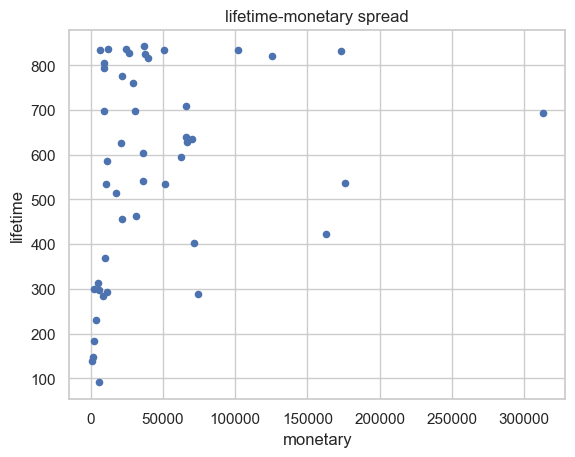

In [63]:
experienced_operators[['lifetime', 'monetary']].plot(kind='scatter', x='monetary', y='lifetime', title = "lifetime-monetary spread");


<Axes: title={'center': 'frequency-monetary spread'}, xlabel='frequency', ylabel='monetary'>

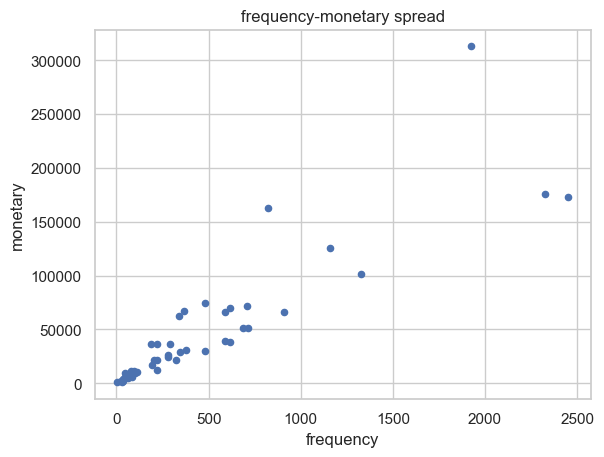

In [64]:
experienced_operators[['monetary', 'frequency']].plot(kind='scatter', x='frequency', y='monetary', title = "frequency-monetary spread")


In [65]:
big_fish = experienced_operators[experienced_operators['monetary']>100000].copy()
not_blooming_yet = experienced_operators[
    (experienced_operators['monetary']<=100000) & 
    (experienced_operators['lifetime']<=400)
].copy()
loyalist = experienced_operators[
    (experienced_operators['monetary']<=100000) & 
    (experienced_operators['lifetime']>400)
].copy()

<Axes: title={'center': 'lifetime-monetary spread\nloyalists'}, xlabel='monetary', ylabel='lifetime'>

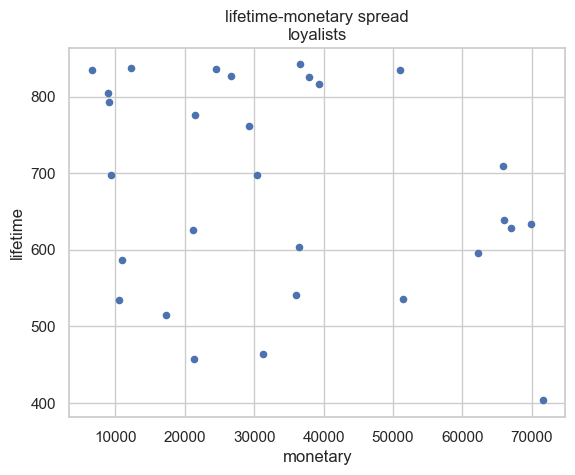

In [66]:
loyalist.sort_values('monetary')
loyalist[['lifetime', 'monetary']].plot(kind='scatter', x='monetary', y='lifetime', title = "lifetime-monetary spread\nloyalists")


<Axes: title={'center': 'lifetime-monetary spread\nbig_fish'}, xlabel='monetary', ylabel='lifetime'>

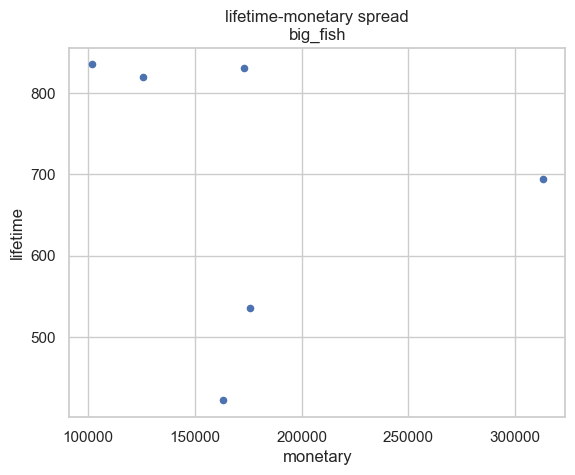

In [67]:
big_fish.sort_values('monetary')
big_fish[['lifetime', 'monetary']].plot(kind='scatter', x='monetary', y='lifetime', title = "lifetime-monetary spread\nbig_fish")


<Axes: title={'center': 'lifetime-monetary spread\nnot_blooming_yet'}, xlabel='monetary', ylabel='lifetime'>

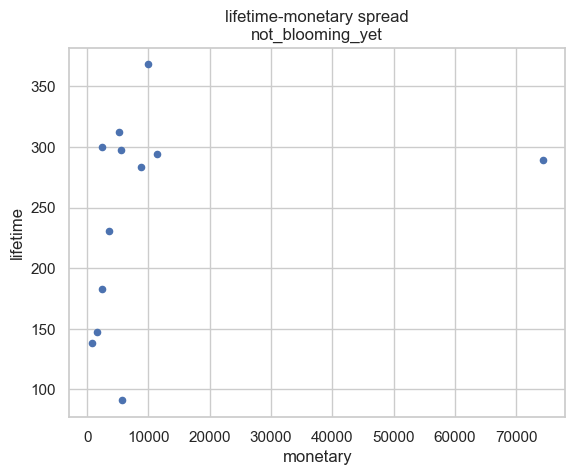

In [68]:
not_blooming_yet.sort_values('monetary')
not_blooming_yet[['lifetime', 'monetary']].plot(kind='scatter', x='monetary', y='lifetime', title = "lifetime-monetary spread\nnot_blooming_yet")


In [133]:
loyalist.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,25.241379,677.551724,352.620690,33888.727586,243.620690,0.209003,0.549988
std,3.699953,136.761415,234.863701,21051.697988,169.023543,0.062284,0.407321
min,23.000000,403.000000,48.000000,6589.400000,25.000000,0.079545,0.060530
25%,23.000000,586.000000,193.000000,17270.000000,124.000000,0.171375,0.329600
50%,24.000000,697.000000,289.000000,30368.670000,188.000000,0.200557,0.417526
75%,25.000000,817.000000,591.000000,51045.180000,359.000000,0.247126,0.745455
max,40.000000,842.000000,908.000000,71605.750000,666.000000,0.363636,1.759305


# Segments of Loyalists

In [136]:
# Loyalists in the 75th percentile for monetary
high_earner_loyalist = loyalist[loyalist['monetary']>=51045.180000]

high_earner_loyalist.sort_values(by='monetary', ascending=False)

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
12,Luminary-US-NY-New York,23,403,709,71605.75,437,0.237986,1.759305
54,WeWork Israel-IL-Jerusalem,24,634,617,69975.75,391,0.235294,0.973186
53,WeWork Israel-IL-Herzliya,24,628,365,66988.83,249,0.188755,0.581210
52,WeWork Israel-IL-Haifa,24,639,591,66079.69,348,0.247126,0.924883
32,Nomadworks-US-NY-New York,24,709,908,65939.50,666,0.159159,1.280677
57,Werqwise-US-CA-San Francisco,25,595,340,62219.75,267,0.168539,0.571429
45,The Yard-US-NY-Brooklyn,23,535,688,51423.50,531,0.171375,1.285981
25,Mindspace-NL-Amsterdam,23,834,713,51045.18,514,0.157588,0.854916


<Axes: title={'center': 'frequency-monetary spread'}, xlabel='frequency', ylabel='monetary'>

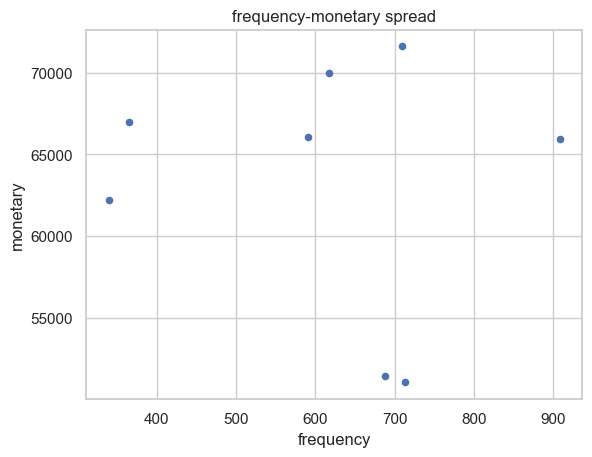

In [137]:
high_earner_loyalist[['monetary', 'frequency']].plot(kind='scatter', x='frequency', y='monetary', title = "frequency-monetary spread")


In [140]:
fdf['operator_key'] = fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']
fdf['operator_full_name'] = fdf['operator_name']+"-"+fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']

pivot_table = fdf.groupby(['operator_name', 'operator_key']).size().unstack(fill_value=0)

def sub_operator_monetary (fdf, key='operator_name'):
    
    # 
    sub_filtered = fdf_[fdf_['date'] < pd.to_datetime('2023-07-01')].copy()

# add-ons exploration

In [150]:
fdf['order_line_item_details']

0        {'date': '2023-07-17', 'hours': 2.5, 'end_time...
1        {'date': '2023-06-28', 'hours': 6.0, 'end_time...
2        {'date': '2023-06-29', 'hours': 5.0, 'end_time...
3        {'days': 1, 'end_date': '2023-04-07', 'quantit...
4        {'days': 1, 'time': None, 'daily': {'time': No...
                               ...                        
21735    {'days': 1, 'end_date': '2023-05-04', 'quantit...
21736    {'date': '2023-06-26', 'hours': 5.0, 'end_time...
21737    {'date': '2023-05-15', 'hours': 8.0, 'end_time...
21738    {'date': '2023-06-02', 'hours': 8.0, 'end_time...
21739    {'date': '2023-04-28', 'hours': 2.0, 'end_time...
Name: order_line_item_details, Length: 21740, dtype: object

In [152]:
fdf.loc[1, 'order_line_item_details']

{'date': '2023-06-28',
 'hours': 6.0,
 'end_time': '1430',
 'quantity': 1,
 'space_id': 'ce51618e-efe9-4dda-a424-a4c82ee5de81',
 'access_id': None,
 'attendees': 12,
 'start_time': '0830',
 'space_layout_id': '408157cc-4a5c-41e4-bfbe-731338b22339',
 'physical_space_id': None}

In [153]:
fdf.loc[2, 'order_line_item_details']

{'date': '2023-06-29',
 'hours': 5.0,
 'end_time': '1330',
 'quantity': 1,
 'space_id': 'ce51618e-efe9-4dda-a424-a4c82ee5de81',
 'access_id': None,
 'attendees': 12,
 'start_time': '0830',
 'space_layout_id': '408157cc-4a5c-41e4-bfbe-731338b22339',
 'physical_space_id': None}

In [174]:
for i, details in enumerate(fdf['order_line_item_details'].head(10)):  # Adjust 10 to however many rows you want to inspect
    print(f"Row {i}:")
    print(details)
    print("-" * 50)


Row 0:
{'date': '2023-07-17', 'hours': 2.5, 'end_time': '1230', 'quantity': 1, 'space_id': '31d186c5-ebd1-4e65-ad8f-6e3f08ffd37f', 'access_id': None, 'attendees': 6, 'start_time': '1000', 'space_layout_id': '75c07f29-7fa6-466f-af6c-0acd0711eacb', 'physical_space_id': None}
--------------------------------------------------
Row 1:
{'date': '2023-06-28', 'hours': 6.0, 'end_time': '1430', 'quantity': 1, 'space_id': 'ce51618e-efe9-4dda-a424-a4c82ee5de81', 'access_id': None, 'attendees': 12, 'start_time': '0830', 'space_layout_id': '408157cc-4a5c-41e4-bfbe-731338b22339', 'physical_space_id': None}
--------------------------------------------------
Row 2:
{'date': '2023-06-29', 'hours': 5.0, 'end_time': '1330', 'quantity': 1, 'space_id': 'ce51618e-efe9-4dda-a424-a4c82ee5de81', 'access_id': None, 'attendees': 12, 'start_time': '0830', 'space_layout_id': '408157cc-4a5c-41e4-bfbe-731338b22339', 'physical_space_id': None}
--------------------------------------------------
Row 3:
{'days': 1, 'end

In [161]:
all_keys = [set(details.keys()) for details in fdf['order_line_item_details'] if details is not None]
same_keys = all(set(all_keys[0]) == k for k in all_keys)

same_keys


False

They do not all have the same keys 

In [166]:
unique_keys = set().union(*all_keys)

unique_keys


{'access_id',
 'add_on_description',
 'add_on_id',
 'add_on_name',
 'add_on_price',
 'add_on_type',
 'attendees',
 'bundled',
 'daily',
 'date',
 'days',
 'days_to_expire',
 'duration',
 'end_date',
 'end_time',
 'expected_arrival_time',
 'hourly',
 'hours',
 'meeting_contact_email',
 'meeting_contact_fullname',
 'meeting_contact_phone',
 'meeting_name',
 'number_of_entries',
 'order_id',
 'physical_space_id',
 'quantity',
 'space_id',
 'space_layout_id',
 'space_offering_id',
 'start_date',
 'start_time',
 'time'}

In [167]:
num_unique_keys = len(unique_keys)

num_unique_keys


32

In [168]:
from collections import Counter

def count_keys_in_list(dict_list):
    key_counts = Counter()
    
    for dict in dict_list:
        if dict is not None:  # Filtering out None values
            key_counts.update(dict.keys())

    return key_counts

# list of dictionaries from the column
dict_list = fdf['order_line_item_details'].tolist()

# defining keys 
key_counts = count_keys_in_list(dict_list)

# Display the counts
for key, count in key_counts.items():
    print(f"{key}: {count}")

date: 2706
hours: 2162
end_time: 2586
quantity: 3907
space_id: 21041
access_id: 2204
attendees: 18127
start_time: 2586
space_layout_id: 18127
physical_space_id: 16556
days: 15421
end_date: 15421
start_date: 15421
time: 14276
daily: 5293
order_id: 5999
meeting_name: 8573
expected_arrival_time: 8573
meeting_contact_email: 8573
meeting_contact_phone: 8573
meeting_contact_fullname: 8573
add_on_id: 2914
add_on_name: 2914
add_on_type: 2914
add_on_price: 2914
days_to_expire: 2914
number_of_entries: 2914
space_offering_id: 2914
add_on_description: 2914
duration: 952
hourly: 706
bundled: 2


In [171]:
# Extract 'add_on_name' 
add_on_values = fdf['order_line_item_details'].apply(lambda x: x.get('add_on_name') if isinstance(x, dict) else None)

unique_add_ons = add_on_values.value_counts()

unique_add_ons

Mindpass Multi (4 Entries)                           862
Mindpass Multi (8 Entries)                           439
Mindpass Multi (12 Entries)                          296
The Yard Multi-Pass (5 Passes)                       195
4 גישות יומיות                                       138
WeWork Multi-Pass (4 passes)                         115
12 גישות יומיות                                       92
Mindpass Multi (4 Passes)                             81
The Malin Multi-Pass (5 Passes)                       76
The Yard Multi-Pass (10 Passes)                       59
The Yard Multi-Pass (30 Passes)                       54
WeWork Multi-Pass (8 passes)                          50
8 גישות יומיות                                        50
The Malin Multi-Pass (10 Passes)                      45
Mindpass Multi (12 Passes)                            44
WeWork Multi-Pass (12 passes)                         43
Mindpass Multi (8 Passes)                             41
Multi-Pass (4 passes)          

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21740 entries, 0 to 21739
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   order_id                 21740 non-null  object             
 1   operator_id              21740 non-null  object             
 2   operator_name            21740 non-null  object             
 3   status                   21740 non-null  object             
 4   source                   21740 non-null  object             
 5   fullname                 21740 non-null  object             
 6   customer_email           21740 non-null  object             
 7   company_name             21740 non-null  object             
 8   confirmation_id          21740 non-null  object             
 9   space_id                 21734 non-null  object             
 10  space_name               21734 non-null  object             
 11  created_at               217

In [182]:
# Extract 'add_on_name' values
add_on_values = fdf['order_line_item_details'].apply(lambda x: x.get('add_on_name') if isinstance(x, dict) and 'add_on_name' in x else None)

# Create a new DataFrame combining the desired columns
add_on_df = pd.DataFrame({
    'operator_key': fdf['operator_key'],
    'operator_full_name': fdf['operator_full_name'],
    'add_on_name': add_on_values
})

In [184]:
add_on_df

,operator_key,operator_full_name,add_on_name
21730,US-NY-New York,Coalition Space-US-NY-New York,Coalition Space Multi Pass (5 Passes)
21731,US-NY-New York,Coalition Space-US-NY-New York,None
21732,US-NY-New York,Coalition Space-US-NY-New York,None
21733,US-NY-New York,Coalition Space-US-NY-New York,Coalition Space Multi Pass (5 Passes)
21734,US-NY-New York,Coalition Space-US-NY-New York,None
21735,US-NY-New York,Coalition Space-US-NY-New York,None
21736,US-CT-Greenwich,gSpace-US-CT-Greenwich,None
21737,US-CT-Fairfield,gSpace-US-CT-Fairfield,None
21738,US-CT-Fairfield,gSpace-US-CT-Fairfield,None
21739,US-CT-Fairfield,gSpace-US-CT-Fairfield,None


In [186]:
filtered_add_on_df = add_on_df[add_on_df['add_on_name'].notnull()]

In [190]:
#renaming columns
filtered_add_on_df.columns = ('operator_key', 'operator', 'add_on_name')

filtered_add_on_df



,operator_key,operator,add_on_name
24,US-CA-Pasadena,FoundrSpace-US-CA-Pasadena,FoundrSpace Multi Pass (5 Passes)
34,US-CA-Pasadena,FoundrSpace-US-CA-Pasadena,FoundrSpace Multi Pass (5 Passes)
174,IL-Tel Aviv,Urban Place-IL-Tel Aviv,UP Multi Day Pass (5 passes)
180,IL-Tel Aviv,Urban Place-IL-Tel Aviv,UP Multi Day Pass (5 passes)
188,IL-Tel Aviv,Urban Place-IL-Tel Aviv,UP Multi Day Pass (10 passes)
...,...,...,...
21656,US-CA-San Francisco,Werqwise-US-CA-San Francisco,Werqwise Multi-Pass (4 Passes)
21710,US-CA-San Francisco,Werqwise-US-CA-San Francisco,Werqwise Multi-Pass (12 Passes)
21713,US-CA-San Francisco,Werqwise-US-CA-San Francisco,Werqwise Multi-Pass (12 Passes)
21730,US-NY-New York,Coalition Space-US-NY-New York,Coalition Space Multi Pass (5 Passes)


In [188]:
loyalist

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
7,Brain Embassy-IL-Tel Aviv,23,697,97,9314.35,62,0.225806,0.139168
8,Brain Embassy-PL-Warsaw,23,698,482,30368.67,359,0.200557,0.690544
12,Luminary-US-NY-New York,23,403,709,71605.75,437,0.237986,1.759305
15,Mindspace-DE-Frankfurt,26,827,281,26652.72,176,0.198864,0.339782
16,Mindspace-DE-Hamburg,23,817,591,39407.03,414,0.202899,0.723378
19,Mindspace-IL-Herzliya,40,804,69,8923.26,55,0.109091,0.085821
22,Mindspace-IL-Ramat Gan,33,793,48,9120.93,25,0.200000,0.060530
23,Mindspace-IL-Tel Aviv,24,842,289,36582.76,188,0.218085,0.343230
24,Mindspace-IL-Yakum,24,586,80,10959.77,33,0.363636,0.136519
25,Mindspace-NL-Amsterdam,23,834,713,51045.18,514,0.157588,0.854916


In [195]:
# operators in 'loyalist' are in 'filtered_add_on_df'
loyalist_operators_in_filtered = loyalist['operator'].isin(filtered_add_on_df['operator'])

# Filter loyalist dataframe to only include operators that are present in 'filtered_add_on_df'
loyalist_in_filtered = loyalist[loyalist_operators_in_filtered]

loyalist_in_filtered.count()


operator           28
recency            28
lifetime           28
frequency          28
monetary           28
total_customers    28
return_rate        28
intensity          28
dtype: int64

In [196]:
loyalist.count()

operator           29
recency            29
lifetime           29
frequency          29
monetary           29
total_customers    29
return_rate        29
intensity          29
dtype: int64

In [197]:
# Create a boolean mask for operators in 'loyalist' that are not in 'loyalist_in_filtered'
difference_mask = ~loyalist['operator'].isin(loyalist_in_filtered['operator'])

# Use the mask to get the rows from 'loyalist' that are not in 'loyalist_in_filtered'
loyalist_difference = loyalist[difference_mask]

loyalist_difference


,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
8,Brain Embassy-PL-Warsaw,23,698,482,30368.67,359,0.200557,0.690544
